# 3D mitotic shape contours

This notebook shows how to replicate the results on mitotic cell and nucleus shapes. 

Before starting, the data should be downloaded from https://open.quiltdata.com/b/allencell/packages/aics/mitotic_annotation.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tifffile
from scipy.ndimage import binary_erosion
import sys
sys.path.append('../Utils/')
from compute_kernel import compute_mmd, compute_kernel_matrix,compute_witness_function,compute_WassKernel_stratified
from compute_kernel import permutation_test_mmd, compute_p_values, hsic2_permutation
from utils_other import  compute_diffusion_map, compute_dimension_reduction_wasskernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def extract_surface_points(volume):
    """Extracts surface points from a 3D volume."""
    eroded = binary_erosion(volume)
    surface = volume & ~eroded  # Keep only the boundary points
    surface_points = np.argwhere(surface)
    return surface_points

def sample_3d_indices(shape, target_size=(32,32,32)):
    slices = [np.linspace(0, s-1, num=n).astype(int) for s,n in zip(shape, target_size)]
    return np.ix_(*slices)

In [4]:
import pandas as pd
df = pd.read_csv('../../shape_dynamics/scripts/cell/metadata.csv')


np.random.seed(42)
cell_types = ['M0',
 'M1M2',
 'M3',
 'M4M5',
 'M6M7_early',
 'M6M7_half',
 'blob',
 'dead',
 'wrong']



np.random.seed(42)
import numpy as np

N = 5767
data = [0]*N#np.zeros( (100,200,3) )

data_full = [0]*N # this is the binary mask
data_cell = [0]*N
import open3d as o3d
idx = 0
import os
directory = '../../shape_dynamics/scripts/cell/'
labels = [0]*N
counter = 0
file_names = [0]*N

N_per_cell = 200


for root, dirs, files in os.walk(directory):
    
    print(root)
    
    for file in files:
        if file.endswith('.tif'):
            
            #print(os.path.join(root, file) )
            im = tifffile.imread(os.path.join(root, file))
            if im.shape[0] > 2:
                
                im = im.swapaxes(1,0)
            imshape = im.shape
                        

            name = os.path.join(root, file)
            name = name[34:]
            
            name = 'crop_seg/'+name
            index = np.where( df['crop_seg'] == name)[0][0]

            
            im_cell = im[ np.ix_([0,1], range(0,imshape[1],6), range(0,imshape[2],15), range(0,imshape[3],15) ) ]
            
            im = im[ np.ix_([0,1], range(0,imshape[1],2), range(0,imshape[2],5), range(0,imshape[3],5) ) ]


            if im.shape[0] == 2:#  and len([i for i, val in enumerate(labels) if val == df['label'][index]]) < 200:
                # data_full[counter] = im
            # if im.shape[0] == 2  and df['label'][index] not in ['blob','dead','wrong'] and len([i for i, val in enumerate(labels) if val == df['label'][index]]) < 200:
                im_cell = im_cell[1,:,:,:]>0#np.where(im_cell[1,:,:,:]>0)
                
                
                im = im[0,:,:,:]>0#np.where(im[0,:,:,:]>0)
                
                
                
                index = range(im[0].shape[0])#np.random.choice( range(im[0].shape[0]), 200, replace=False)
                data[counter] = [0]#np.zeros( (200,3) )
                data[counter] = np.concatenate( (im[0].reshape(-1,1), im[1].reshape(-1,1), im[2].reshape(-1,1)   )  ,axis=1 )
                data[counter] = extract_surface_points(im)

                
                data_cell[counter] = [0]
                data_cell[counter] = np.concatenate( (im_cell[0].reshape(-1,1), im_cell[1].reshape(-1,1), im_cell[2].reshape(-1,1)   )  ,axis=1 )
                data_cell[counter] = extract_surface_points(im_cell)

                print(os.path.join(root, file))

                index = np.where( df['crop_seg'] == name)[0][0]
                labels[counter] = df['label'][index]
                
                file_names[counter] = os.path.join(root, file)
                counter += 1
                print(counter)
                # if counter > 600:
                #     stop

../../shape_dynamics/scripts/cell/
../../shape_dynamics/scripts/cell/297294b1_segmentation.ome.tif
1
../../shape_dynamics/scripts/cell/703cd353_segmentation.ome.tif
2
../../shape_dynamics/scripts/cell/98b7e181_segmentation.ome.tif
3
../../shape_dynamics/scripts/cell/156059ee_segmentation.ome.tif
4
../../shape_dynamics/scripts/cell/dd4654c6_segmentation.ome.tif
5
../../shape_dynamics/scripts/cell/fa2567e9_segmentation.ome.tif
6
../../shape_dynamics/scripts/cell/95c4d915_segmentation.ome.tif
7
../../shape_dynamics/scripts/cell/b4e741b2_segmentation.ome.tif
8
../../shape_dynamics/scripts/cell/8965c8ae_segmentation.ome.tif
9
../../shape_dynamics/scripts/cell/9abb291f_segmentation.ome.tif
10
../../shape_dynamics/scripts/cell/cf2f5720_segmentation.ome.tif
11
../../shape_dynamics/scripts/cell/8e0324db_segmentation.ome.tif
12
../../shape_dynamics/scripts/cell/bc12e357_segmentation.ome.tif
13
../../shape_dynamics/scripts/cell/95005784_segmentation.ome.tif
14
../../shape_dynamics/scripts/cell/0c

In [5]:
N_shapes = counter
for i in range(N_shapes):
    data_cell[i] = np.array(data_cell[i], dtype=float)
    print(data_cell[i].shape[0])
    data[i] = np.array(data[i], dtype=float)
    

444
780
739
695
593
492
394
399
585
411
606
585
696
284
448
616
873
787
420
689
625
349
659
978
844
633
583
792
510
410
424
582
573
405
140
692
448
605
517
417
908
492
494
651
696
718
598
776
512
630
529
464
501
670
394
685
664
638
622
456
373
580
542
705
120
704
420
457
485
777
555
467
736
421
653
425
727
618
451
437
555
416
618
402
614
430
376
576
340
515
704
658
712
557
420
538
415
724
593
725
171
561
580
543
663
655
446
552
503
449
452
641
648
597
692
742
763
810
681
685
454
682
769
364
712
624
396
448
586
266
613
297
405
429
431
469
544
724
691
709
398
591
622
482
487
688
678
800
628
446
686
502
747
339
543
552
474
548
637
525
688
699
640
712
461
577
808
392
448
408
768
634
662
827
517
493
670
781
612
373
611
383
636
543
528
442
687
394
742
695
704
656
646
615
557
635
568
510
447
508
359
354
723
376
457
662
679
544
612
394
811
827
432
632
636
437
726
197
331
599
520
582
636
307
627
433
375
725
642
486
702
434
435
525
404
519
623
592
600
920
507
632
797
844
644
473
635
638
733
702


The cell below computes the stratified distance as well as the quantile embeddings:

In [5]:
import time
from compute_kernel import compute_WassKernel_stratified
start = time.time()
# K_W_cell = compute_kernel_matrix(data_cell[0:N_shapes],normalize=False,kernel_type='W_stratified',n_quantile=200, return_distance=True)
# K_Ws_cell, embed_Ws_cell = compute_WassKernel_stratified(data_cell[0:N_shapes], n_align = 100, n_quantile = 100, metric='Euclidean',normalize=False, return_distance=True)
# np.save('All_3DShape_W_stratified_newscore.npy',K_Ws_cell)
# np.save('All_3DShape_W_stratified_embed_newscore.npy',embed_Ws_cell)
K_Ws, embed_Ws = compute_WassKernel_stratified(data[0:N_shapes],n_align = 100, n_quantile = 100,metric='Euclidean',normalize=False, return_distance=True)
np.save('Results/All_3DShape_Nucleus_W_stratified.npy',K_Ws)
np.save('Results/All_3DShape_Nucleus_W_stratified_embed.npy',embed_Ws)
print(time.time()-start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
embed_Ws = np.load('../../shape_dynamics/Scripts-clean/Cell_3D/All_3DShape_Nucleus_W_stratified_embed.npy')
embed_Ws_cell = np.load('../../shape_dynamics/Scripts-clean/Cell_3D/All_3DShape_W_stratified_embed_newscore.npy')



Next, we use UMAP to embed the high-dimensional embeddings in a 2D space.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/k7/s0t_zwg11h56xb5xp339s5pm0000gp/T/ipykernel_94745/723085364.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax1.scatter(mapper_ws[idx, 0], mapper_ws[idx, 1],  s=30, label=class_names[i], c=color_list[i])


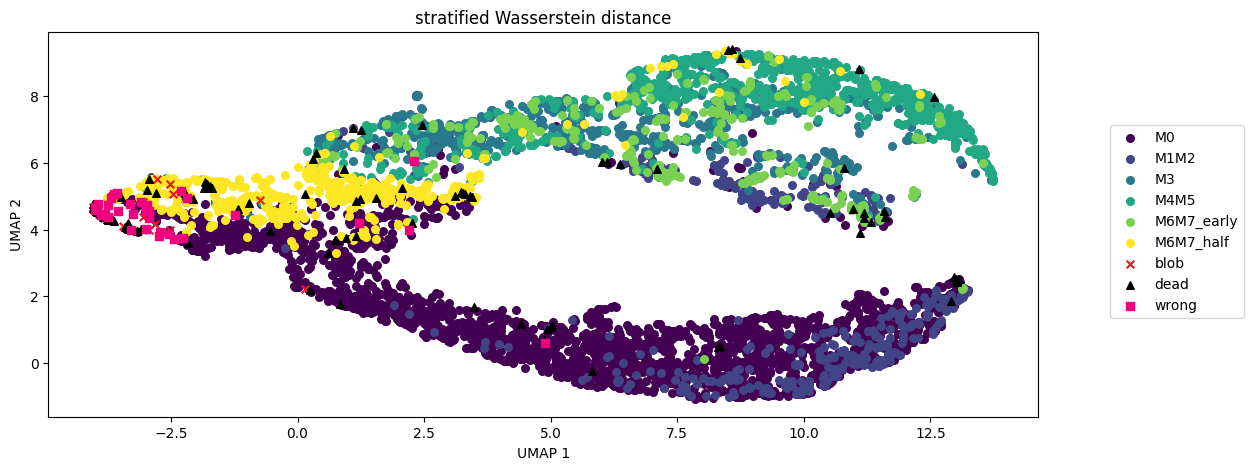

In [9]:
class_names = cell_types
labels = labels[0:N_shapes]
import umap
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
from matplotlib import rcParamsDefault
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
plt.rcParams["axes.prop_cycle"] = rcParamsDefault["axes.prop_cycle"]
fig = plt.figure(figsize=(12, 5))

outlier_markers = ['x', '^', 's']
# Smooth gradient for continuous classes using viridis
viridis = plt.get_cmap('viridis', 6)
continuous_colors = [viridis(i) for i in range(6)]

# Visually distinct outlier colors
outlier_colors = ['#e41a1c', '#000000', '#f0027f']  # red, black, magenta

# Combine
color_list = continuous_colors + outlier_colors

# Use 2D UMAP
fit = umap.UMAP(n_components=2, random_state=52)
# fit = MDS(n_components=2, random_state=42)
mapper_ws = fit.fit_transform(np.hstack([embed_Ws,embed_Ws_cell]))
from sklearn.manifold import MDS


ax1 = fig.add_subplot(111)#, projection='3d')

for i in range(len(class_names)):

    # idx = np.where(np.array(class_all_num) == i)[0]
    idx = [j for j in range(len(labels)) if labels[j] == class_names[i] ]
    if i < len(class_names)-3:
        ax1.scatter(mapper_ws[idx, 0], mapper_ws[idx, 1],  s=30, label=class_names[i], c=color_list[i])
    else:
        ax1.scatter(mapper_ws[idx, 0], mapper_ws[idx, 1],  s=30, label=class_names[i], c=color_list[i], marker=outlier_markers[i-(len(class_names)-3)] )

ax1.set_title('stratified Wasserstein distance')
# ax.legend()
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")

# Combine handles and labels from both axes
handles, labels_axis = [], []
for ax in [ax1]:#, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels_axis += l

# Create a single legend outside the subplots
fig.legend(handles, labels_axis, loc='center left', bbox_to_anchor=(1.01, 0.5), borderaxespad=0.)
plt.subplots_adjust(right=0.95)  # leave space on the right
# plt.savefig('Figures/embeddings.png', bbox_inches='tight')
plt.show()

The cell below computes distances between mitotic stages

In [11]:
species = set(labels)

idx_good = []
for i in range(len(labels)):
    if labels[i][0] == 'M':
        idx_good += [i]
print(len(idx_good))

species = ['M0','M1M2','M3','M4M5','M6M7_early','M6M7_half','blob','wrong','dead']
idx_species = [0]*len(species)
for i in range(len(species)):
    idx_species[i] = []

    for j in range(len(labels)):
        if labels[j] == species[i] and j in idx_good:
            k = np.where(np.array(idx_good) == j)[0]
            if True:#witness_scores[k] > -100:#-0.2*1E-10:
                idx_species[i] += [j]
        else:
            if labels[j] == species[i]:
                idx_species[i] += [j]
    print(len(idx_species[i]))

5606
2516
441
823
927
338
561
20
35
103


/var/folders/k7/s0t_zwg11h56xb5xp339s5pm0000gp/T/ipykernel_94745/2091683771.py:68: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points_2d[i, 0], points_2d[i, 1], s=len(idx_species[i]), label=class_names[i], c=color_list[i])


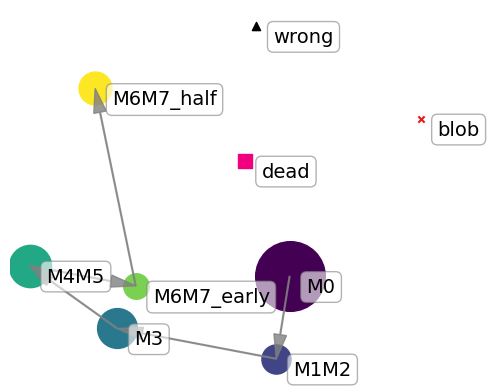

In [14]:
X = np.hstack([embed_Ws,embed_Ws_cell])
# X = X[idx_good,:]
import scipy
D = scipy.spatial.distance.pdist(X)
D = scipy.spatial.distance.squareform(D)


from compute_kernel import mmd2_u_stat, mmd2_permutation

import ot
gamma = np.median(D)/5
K = np.exp(-D/gamma)
MMD_all = np.zeros((len(idx_species),len(idx_species)))
MMD_V_all = np.zeros((len(idx_species),len(idx_species)))
p_value_all = np.zeros((len(idx_species),len(idx_species)))
for i in range(len(idx_species)):
    for j in range(i,len(idx_species)):
        K_XX = K[np.ix_(idx_species[i], idx_species[i])]
        K_XY = K[np.ix_(idx_species[i], idx_species[j])]
        K_YY = K[np.ix_(idx_species[j], idx_species[j])]

        idx_all = list(idx_species[i]) + list(idx_species[j])
        # MMD_all[i,j] = compute_mmd(K_XX,K_YY, K_XY)
        # gamma = np.median(D[np.ix_(idx, idx_all)])/5
        result = mmd2_permutation(np.exp(-D[np.ix_(idx_all, idx_all)]/gamma), len(idx_species[i]) )
        # result = mmd2_permutation(-D[ np.ix_(idx_all, idx_all) ], len(idx_species[i]))
        MMD_all[i,j] = result.estimate#
        

        if np.isnan(MMD_all[i,j]):
            print(i)
            print(j)
            # stop
        # MMD_all[i,j] = result.estimate
        # MMD_all[j,i] = result.estimate #
        MMD_all[j,i] = MMD_all[i,j]


MMD_all = MMD_all - np.diag(np.diag( MMD_all))
MMD_all[MMD_all<0] = 1E-5
MMD_all = np.sqrt(MMD_all)

import umap
from sklearn.manifold import MDS
# Perform MDS
fit = MDS(n_components=2, dissimilarity='precomputed', random_state=12, n_init=10, max_iter=1000)
# fit = umap.UMAP(metric="precomputed", n_components=2, random_state=52)

points_2d = fit.fit_transform(MMD_all)
# points_2d,_ = compute_diffusion_map(MMD_all,n_components=2)

from adjustText import adjust_text


import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from adjustText import adjust_text


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)#,projection='3d')

for i in range(len(species)):
    # idx = np.where(np.array(class_all_num) == i)[0]
    idx = [j for j in range(len(labels)) if labels[j] == species[i] ]

    if i < len(class_names)-3:
        ax.scatter(points_2d[i, 0], points_2d[i, 1], s=len(idx_species[i]), label=class_names[i], c=color_list[i])
    else:
        ax.scatter(points_2d[i, 0], points_2d[i, 1], s=len(idx_species[i]), label=class_names[i], c=color_list[i], marker=outlier_markers[i-(len(class_names)-3)] )

# Add legend
# ax.legend(title='Mitotic Stages', loc='upper left', fontsize=14, title_fontsize=14)
plt.axis('off')
# Annotate with labels and use adjustText
texts = []
for i, label in enumerate(species):
    txt = ax.text(points_2d[i, 0]+0.02, points_2d[i, 1]-0.02, label,
                  fontsize=14,
                  bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray', boxstyle='round,pad=0.3'))
    texts.append(txt)

stage_order = ['M0', 'M1M2', 'M3', 'M4M5', 'M6M7_early', 'M6M7_half']
stage_to_xy = {label: points_2d[i] for i, label in enumerate(species)}

# fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

# Draw arrows along biological progression
for i in range(len(stage_order) - 1):
    x0, y0 = stage_to_xy[stage_order[i]]
    x1, y1 = stage_to_xy[stage_order[i+1]]
    ax.arrow(x0, y0, x1 - x0, y1 - y0,
             length_includes_head=True,
             head_width=0.015, head_length=0.03,
             fc='gray', ec='gray', alpha=0.8)

# Labels and grid
# plt.title("MDS of cell populations in mitotic stages", fontsize=14)
plt.xlabel("MDS1",fontsize=14)
plt.ylabel("MDS2",fontsize=14)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

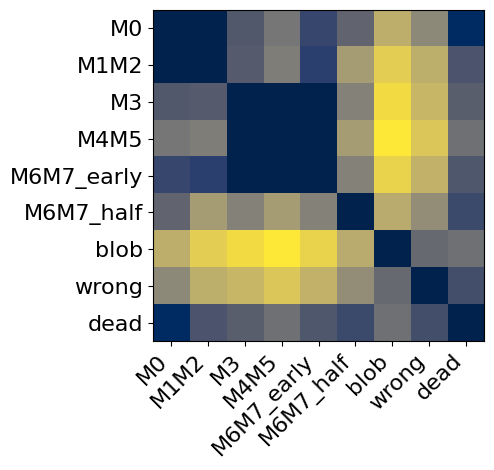

In [17]:
np.fill_diagonal(MMD_all, 0)  # use NaN so it's ignored by imshow
plt.imshow(np.sqrt(MMD_all) ,cmap='cividis')
# plt.clim(np.sqrt(MMD_all[0,1]-0.05),np.sqrt(MMD_all).max())
plt.clim(np.sqrt(MMD_all[2,3]),np.sqrt(MMD_all).max())
# Add row and column labels
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=45, ha='right',fontsize=16)
plt.yticks(ticks=np.arange(len(species)), labels=species,fontsize=16)
plt.tight_layout()